<center><h1>Domain Adaptation</h1></center>

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation**.
https://arxiv.org/abs/1409.7495

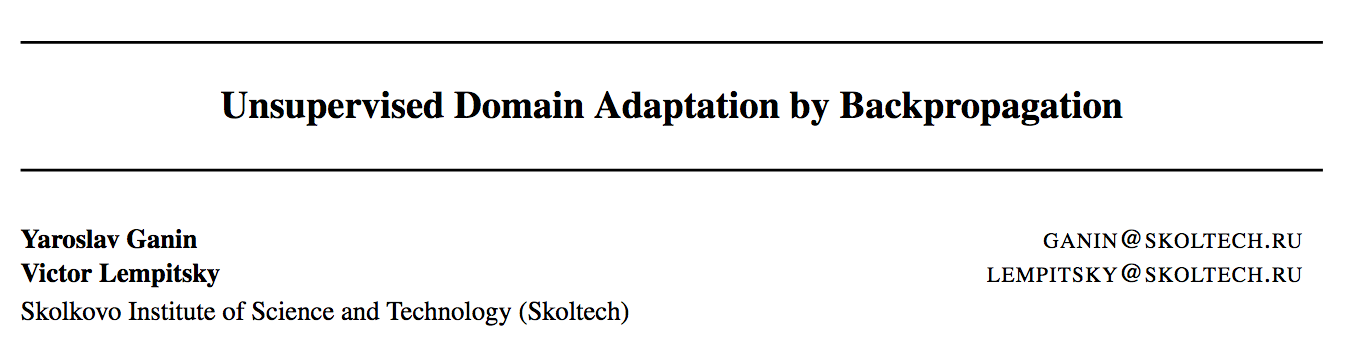

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [268]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [4]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-12-26 09:53:41--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2821 (2.8K) [text/plain]
Saving to: ‘mnistm.py.1’

mnistm.py.1         100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-12-26 09:53:41 (40.0 MB/s) - ‘mnistm.py.1’ saved [2821/2821]



In [5]:
from mnistm import create_mnistm
create_mnistm()


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [6]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [7]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

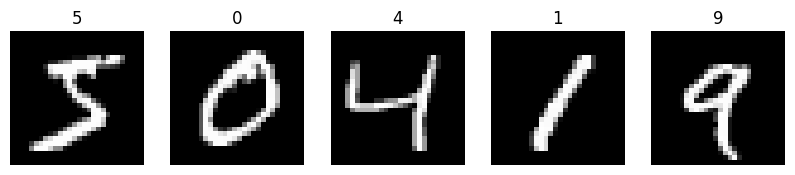

In [8]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [9]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

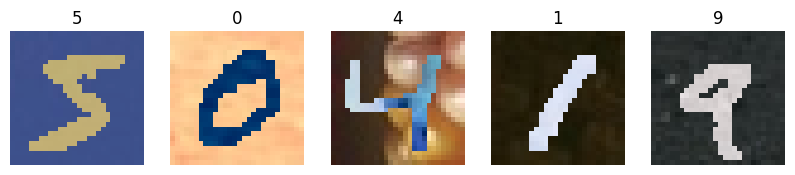

In [10]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

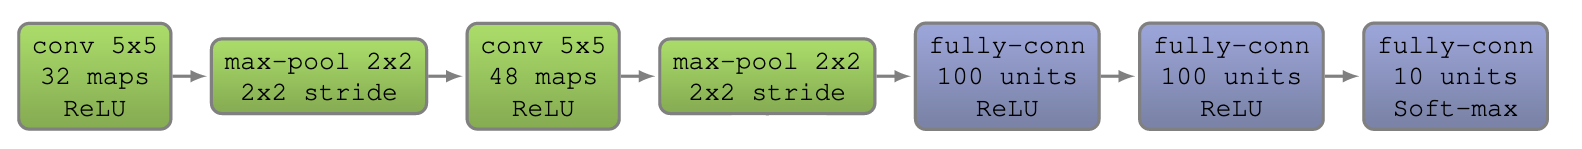

In [88]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3,32,5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2),
        nn.Conv2d(32,48,5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )

    # 48*7*7 = 2352
    self.classif = nn.Sequential(
        nn.Linear(in_features=2352,out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100,out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100,out_features=10)
        # nn.Softmax(dim=1)
    )

  def forward(self, x):

    # get features from CNN part
    features = self.cnn(x)
    features = features.view(features.size(0),-1)
    return self.classif(features)

NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [89]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [90]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"\nTest loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.23934
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.04394
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.02741
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.01972
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.01536
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.01264
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.0106
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.00909
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.00791
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.00693
	Learning rate = 0.0016556002607617019

Test loss: 0.02587, test acc: 99.22


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [91]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.68059, test acc: 55.09


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

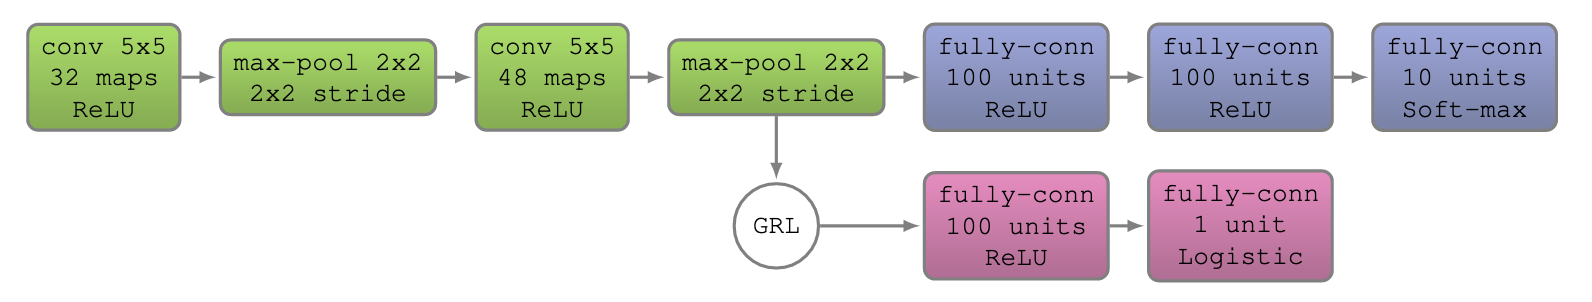

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [80]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = factor*grad

    return reversed_grad, None

In [83]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

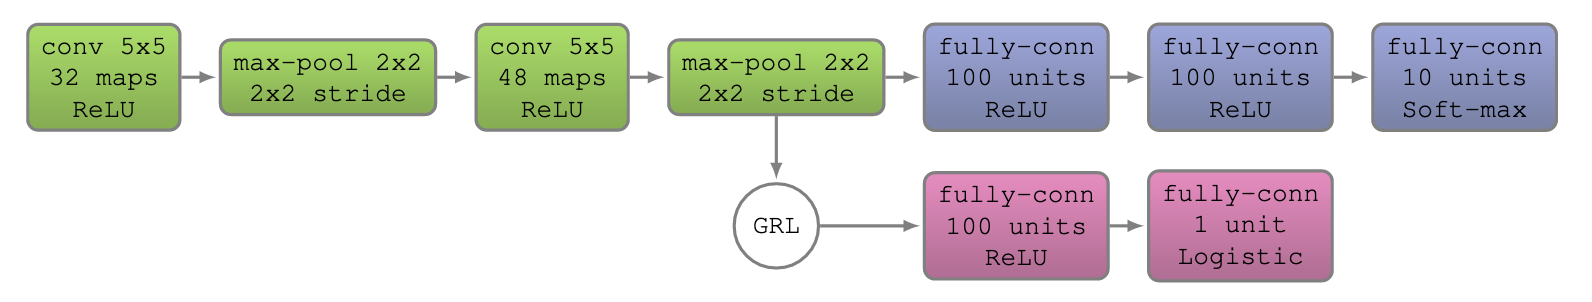

In [97]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3,32,5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2),
        nn.Conv2d(32,48,5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )

    # 48*7*7 = 2352
    self.classif = nn.Sequential(
        nn.Linear(in_features=2352,out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100,out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100,out_features=10)

        # implicitly done in cross_entropy loss
        # nn.Softmax(dim=1)
    )

    self.domain = nn.Sequential(
        nn.Linear(in_features=2352,out_features=100),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=100,out_features=1)

        # implicitily done in the binary_cross_entropy_with_logits loss
        # nn.Sigmoid()
    )

  def forward(self, x, factor=1):

    # get features from CNN part
    features = self.cnn(x)
    features = features.view(features.size(0),-1)
    class_pred = self.classif(features)
    domain_pred = self.domain(GradientReversal.apply(features,-1 * factor))

    return class_pred, domain_pred

In [98]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [94]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

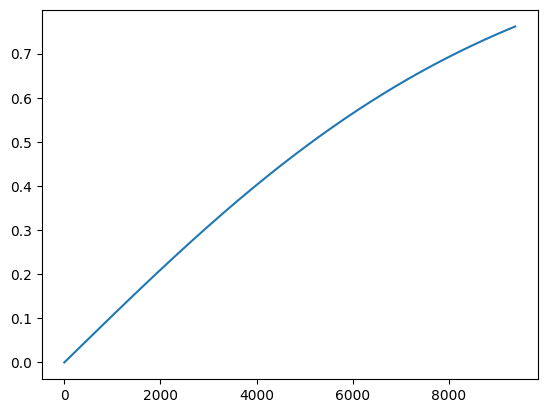

In [95]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)

Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [139]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
cls_losses = []
domain_losses = []
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))
    domain_labels = torch.cat((torch.ones(xs.size(0)),torch.zeros(xt.size(0))))
    domain_labels = domain_labels.cuda()


    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # the cross entropy is calculated only on source data
    # we will extract the same first length target label of the source data
    # because the concatenation is done (source_data + target_data)
    cls_logits_source = cls_logits[:ys.size(0)]
    ce = F.cross_entropy(cls_logits_source,ys)

    bce = F.binary_cross_entropy_with_logits(domain_logits[:,0],domain_labels)

    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  cls_losses.append(cls_loss)
  domain_losses.append(domain_loss)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

GRL factor 0.0
Epoch 0, class loss: 0.24544, domain loss: 0.0426
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.05004, domain loss: 0.06438
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03259, domain loss: 0.08256
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02685, domain loss: 0.09843
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02487, domain loss: 0.11455
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.03832, domain loss: 0.13065
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.03576, domain loss: 0.16076
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.03819, domain loss: 0.18972
GRL factor 0.379948962255225
Epoch 8, class loss: 0.05434, domain loss: 0.24265
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.04765, domain loss: 0.2797
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.03843, domain loss: 0.26968
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.03217, domain loss: 0.26646
GRL factor 0.5370495669980351
Epoch 12, cl

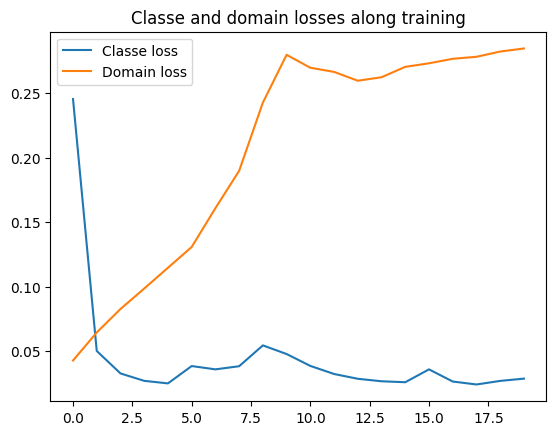

In [140]:
plt.title("Classe and domain losses along training")
plt.plot(np.arange(epochs),cls_losses)
plt.plot(np.arange(epochs),domain_losses)
plt.legend(["Classe loss","Domain loss"])
plt.show()

In [141]:
__c_acc, __d_acc, __c_loss, __d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {__c_loss} / {__c_acc}%, Domain loss/acc: {__d_loss} / {__d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

[SOURCE] Class loss/acc: 0.03567 / 98.84%, Domain loss/acc: 0.51133 / 86.52%
[TARGET] Class loss/acc: 0.69637 / 79.16%, Domain loss/acc: 0.59496 / 57.42%


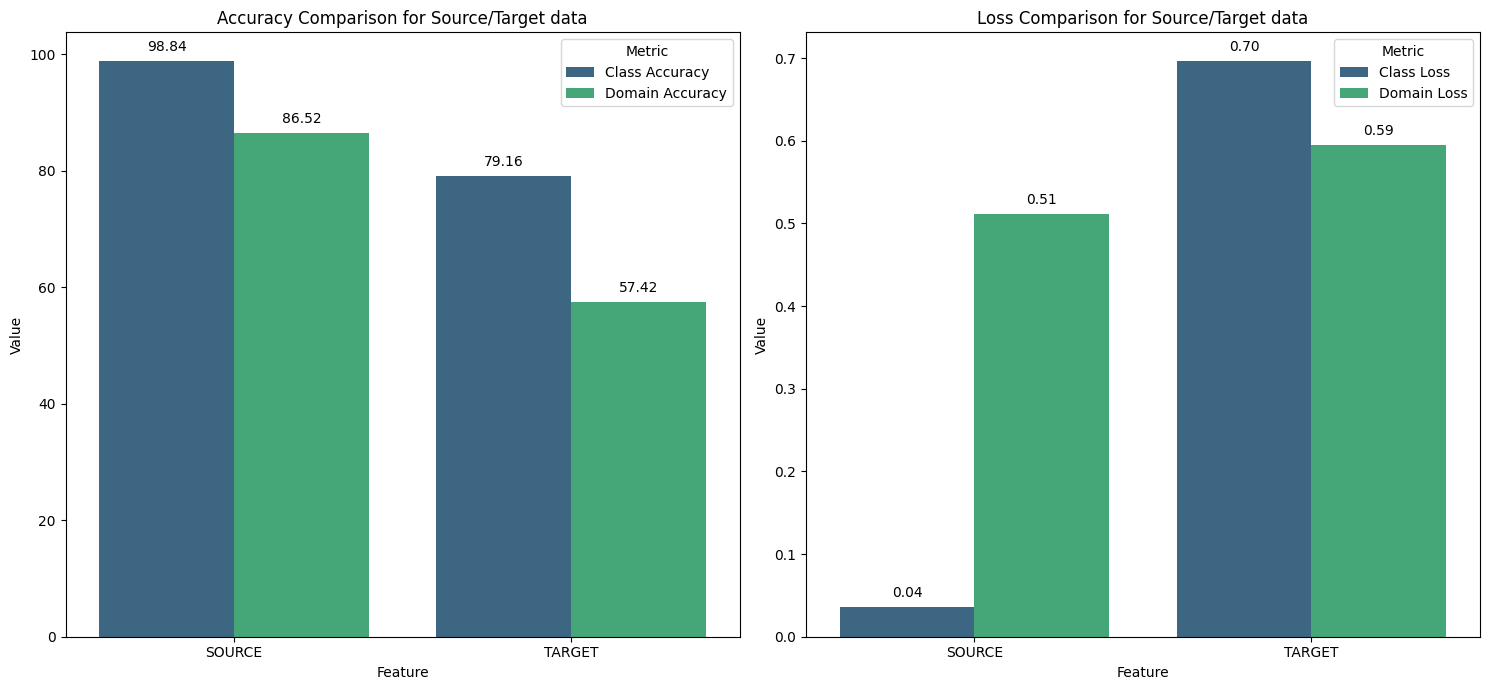

In [142]:

feature_values = ["SOURCE", "TARGET"]
classe_acc = [__c_acc, c_acc]
domain_acc = [__d_acc, d_acc]
classe_loss = [__c_loss, c_loss]
domain_loss = [__d_loss, d_loss]

df_acc = pd.DataFrame({'Feature': feature_values * 2,
                       'Value': classe_acc + domain_acc,
                       'Metric': ['Class Accuracy'] * len(feature_values) +
                                 ['Domain Accuracy'] * len(feature_values)})

df_loss = pd.DataFrame({'Feature': feature_values * 2,
                        'Value': classe_loss + domain_loss,
                        'Metric': ['Class Loss'] * len(feature_values) +
                                  ['Domain Loss'] * len(feature_values)})


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))


sns.barplot(ax=axes[0], x='Feature', y='Value', hue='Metric', data=df_acc, palette='viridis')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Value')
axes[0].set_title('Accuracy Comparison for Source/Target data')


for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')


sns.barplot(ax=axes[1], x='Feature', y='Value', hue='Metric', data=df_loss, palette='viridis')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Value')
axes[1].set_title('Loss Comparison for Source/Target data')


for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [44]:
from sklearn.manifold import TSNE

In [130]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)
indexes = np.random.permutation(len(source_emb))[:1000]
emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))
tsne = TSNE(n_components=2)
naive_emb_2d = tsne.fit_transform(emb)


source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)
indexes = np.random.permutation(len(source_emb))[:1000]
emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))
tsne = TSNE(n_components=2)
dann_emb_2d = tsne.fit_transform(emb)

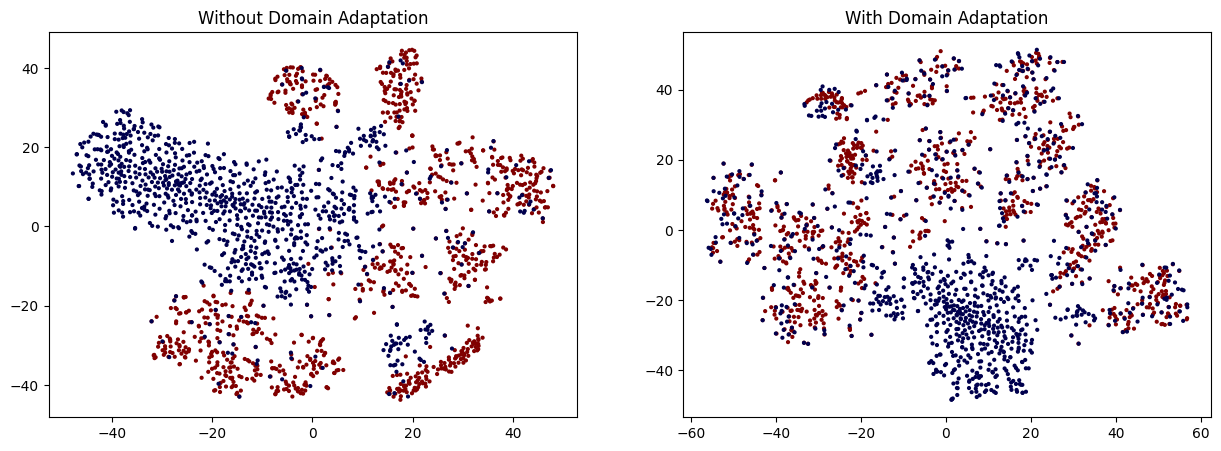

In [134]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(naive_emb_2d[:, 0], naive_emb_2d[:, 1], c=domains, s=4, cmap=plt.cm.get_cmap("seismic", 2))
plt.title("Without Domain Adaptation")

plt.subplot(122)
plt.scatter(dann_emb_2d[:, 0], dann_emb_2d[:, 1], c=domains, s=4, cmap=plt.cm.get_cmap("seismic", 2))
plt.title("With Domain Adaptation")
plt.show()

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

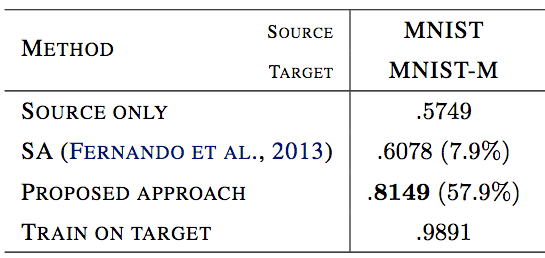

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

## More Epochs

In [186]:
epochs = 40

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
cls_losses = []
domain_losses = []
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))
    domain_labels = torch.cat((torch.ones(xs.size(0)),torch.zeros(xt.size(0))))
    domain_labels = domain_labels.cuda()


    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # the cross entropy is calculated only on source data
    # we will extract the same first length target label of the source data
    # because the concatenation is done (source_data + target_data)
    cls_logits_source = cls_logits[:ys.size(0)]
    ce = F.cross_entropy(cls_logits_source,ys)

    bce = F.binary_cross_entropy_with_logits(domain_logits[:,0],domain_labels)

    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()


  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  cls_losses.append(cls_loss)
  domain_losses.append(domain_loss)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

GRL factor 0.0
Epoch 0, class loss: 0.23608, domain loss: 0.04279
GRL factor 0.024994792968420665
Epoch 1, class loss: 0.04925, domain loss: 0.02987
GRL factor 0.049958374957880025
Epoch 2, class loss: 0.03027, domain loss: 0.06282
GRL factor 0.0748596906874992
Epoch 3, class loss: 0.0217, domain loss: 0.07369
GRL factor 0.0996679946249559
Epoch 4, class loss: 0.01676, domain loss: 0.07619
GRL factor 0.12435300177159614
Epoch 5, class loss: 0.01399, domain loss: 0.08001
GRL factor 0.14888503362331806
Epoch 6, class loss: 0.01303, domain loss: 0.09326
GRL factor 0.17323515783466026
Epoch 7, class loss: 0.01409, domain loss: 0.11105
GRL factor 0.197375320224904
Epoch 8, class loss: 0.0172, domain loss: 0.13534
GRL factor 0.22127846789844408
Epoch 9, class loss: 0.03493, domain loss: 0.17971
GRL factor 0.2449186624037092
Epoch 10, class loss: 0.03496, domain loss: 0.19824
GRL factor 0.2682711820216015
Epoch 11, class loss: 0.03061, domain loss: 0.21836
GRL factor 0.2913126124515908
Epoch 

In [187]:
__c_acc, __d_acc, __c_loss, __d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {__c_loss} / {__c_acc}%, Domain loss/acc: {__d_loss} / {__d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

[SOURCE] Class loss/acc: 0.05202 / 98.76%, Domain loss/acc: 0.46513 / 87.43%
[TARGET] Class loss/acc: 1.01387 / 79.65%, Domain loss/acc: 0.6703 / 50.48%


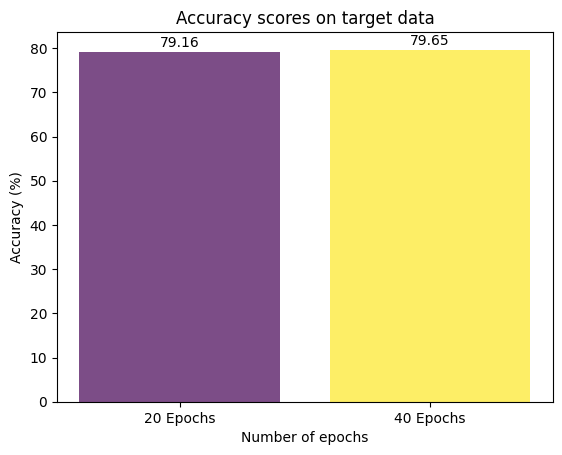

In [189]:
liste_epochs = ['20 Epochs', '40 Epochs']
accuracies = [79.16, 79.65]

colors = plt.cm.viridis(np.linspace(0, 1, len(liste_epochs)), alpha=0.7)

bars = plt.bar(liste_epochs, accuracies, color=colors)

for bar, v in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(v),
             color='black', ha='center', va='bottom')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy scores on target data')
plt.show()

## Different GRL factor scheduling

### Disable First

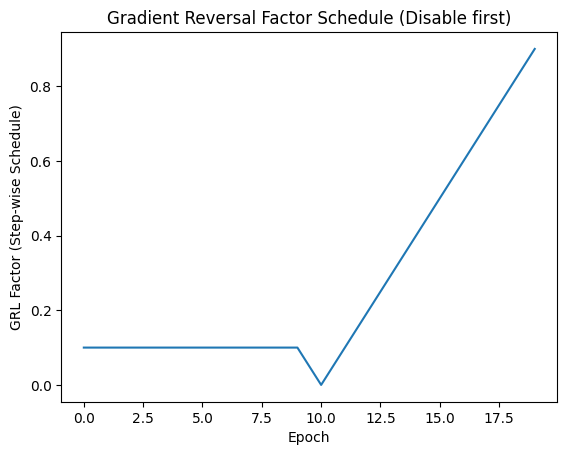

In [177]:
import matplotlib.pyplot as plt

epochs = 20
num_epochs = epochs
grl_lambda_stepwise = lambda current_epoch, num_epochs: 1e-1 if current_epoch < num_epochs // 2 else 2.0 * (current_epoch / num_epochs) - 1.0

x_stepwise = [i for i in range(epochs)]
y_stepwise = [grl_lambda_stepwise(i, epochs) for i in x_stepwise]

plt.plot(x_stepwise, y_stepwise)
plt.xlabel('Epoch')
plt.ylabel('GRL Factor (Step-wise Schedule)')
plt.title('Gradient Reversal Factor Schedule (Disable first)')
plt.show()


In [175]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

lmbd = lambda current_epoch: 1e-1 if current_epoch < epochs // 2 else 2.0 * (current_epoch / epochs) - 1.0


b = 0
cls_losses = []
domain_losses = []
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )
  b += 1

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))
    domain_labels = torch.cat((torch.ones(xs.size(0)),torch.zeros(xt.size(0))))
    domain_labels = domain_labels.cuda()


    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # the cross entropy is calculated only on source data
    # we will extract the same first length target label of the source data
    # because the concatenation is done (source_data + target_data)
    cls_logits_source = cls_logits[:ys.size(0)]
    ce = F.cross_entropy(cls_logits_source,ys)

    bce = F.binary_cross_entropy_with_logits(domain_logits[:,0],domain_labels)

    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  cls_losses.append(cls_loss)
  domain_losses.append(domain_loss)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

GRL factor 0.1
Epoch 0, class loss: 0.25821, domain loss: 0.08483
GRL factor 0.1
Epoch 1, class loss: 0.05108, domain loss: 0.08731
GRL factor 0.1
Epoch 2, class loss: 0.03246, domain loss: 0.08802
GRL factor 0.1
Epoch 3, class loss: 0.02352, domain loss: 0.08164
GRL factor 0.1
Epoch 4, class loss: 0.01834, domain loss: 0.07752
GRL factor 0.1
Epoch 5, class loss: 0.01458, domain loss: 0.07436
GRL factor 0.1
Epoch 6, class loss: 0.01196, domain loss: 0.07162
GRL factor 0.1
Epoch 7, class loss: 0.01003, domain loss: 0.07209
GRL factor 0.1
Epoch 8, class loss: 0.00858, domain loss: 0.07191
GRL factor 0.1
Epoch 9, class loss: 0.00685, domain loss: 0.06066
GRL factor 0.0
Epoch 10, class loss: 0.00599, domain loss: 0.06121
GRL factor 0.10000000000000009
Epoch 11, class loss: 0.00974, domain loss: 0.08639
GRL factor 0.19999999999999996
Epoch 12, class loss: 0.02959, domain loss: 0.16238
GRL factor 0.30000000000000004
Epoch 13, class loss: 0.04241, domain loss: 0.21988
GRL factor 0.39999999999

In [176]:
__c_acc, __d_acc, __c_loss, __d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {__c_loss} / {__c_acc}%, Domain loss/acc: {__d_loss} / {__d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

[SOURCE] Class loss/acc: 0.0407 / 98.68%, Domain loss/acc: 0.54002 / 72.66%
[TARGET] Class loss/acc: 1.40709 / 71.95%, Domain loss/acc: 1.47519 / 49.8%


### Linear

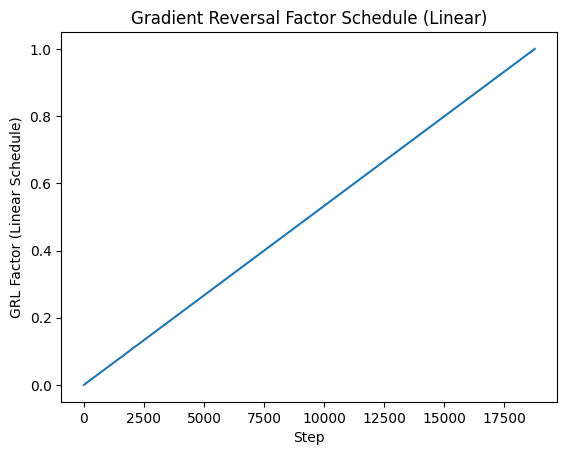

In [179]:
max_steps = len(source_train_loader) * epochs

grl_lambda_linear = lambda current_step, max_steps: current_step / max_steps

x_linear = [i for i in range(max_steps)]
y_linear = [grl_lambda_linear(i, max_steps) for i in x_linear]

plt.plot(x_linear, y_linear)
plt.xlabel('Step')
plt.ylabel('GRL Factor (Linear Schedule)')
plt.title('Gradient Reversal Factor Schedule (Linear)')
plt.show()


In [180]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
max_steps = len(source_train_loader) * epochs
lmbd = lambda current_step : current_step / max_steps

b = 0
cls_losses = []
domain_losses = []
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1
    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))
    domain_labels = torch.cat((torch.ones(xs.size(0)),torch.zeros(xt.size(0))))
    domain_labels = domain_labels.cuda()


    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # the cross entropy is calculated only on source data
    # we will extract the same first length target label of the source data
    # because the concatenation is done (source_data + target_data)
    cls_logits_source = cls_logits[:ys.size(0)]
    ce = F.cross_entropy(cls_logits_source,ys)

    bce = F.binary_cross_entropy_with_logits(domain_logits[:,0],domain_labels)

    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  cls_losses.append(cls_loss)
  domain_losses.append(domain_loss)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

GRL factor 0.0
Epoch 0, class loss: 0.23415, domain loss: 0.0489
GRL factor 0.05
Epoch 1, class loss: 0.04785, domain loss: 0.07224
GRL factor 0.1
Epoch 2, class loss: 0.03087, domain loss: 0.09332
GRL factor 0.15
Epoch 3, class loss: 0.02685, domain loss: 0.10569
GRL factor 0.2
Epoch 4, class loss: 0.02508, domain loss: 0.12207
GRL factor 0.25
Epoch 5, class loss: 0.02897, domain loss: 0.14605
GRL factor 0.3
Epoch 6, class loss: 0.03714, domain loss: 0.17896
GRL factor 0.35
Epoch 7, class loss: 0.04248, domain loss: 0.23507
GRL factor 0.4
Epoch 8, class loss: 0.05985, domain loss: 0.22792
GRL factor 0.45
Epoch 9, class loss: 0.0449, domain loss: 0.26911
GRL factor 0.5
Epoch 10, class loss: 0.03833, domain loss: 0.26892
GRL factor 0.55
Epoch 11, class loss: 0.02491, domain loss: 0.26079
GRL factor 0.6
Epoch 12, class loss: 0.02448, domain loss: 0.26441
GRL factor 0.65
Epoch 13, class loss: 0.0254, domain loss: 0.26716
GRL factor 0.7
Epoch 14, class loss: 0.02697, domain loss: 0.27733
G

In [181]:
__c_acc, __d_acc, __c_loss, __d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {__c_loss} / {__c_acc}%, Domain loss/acc: {__d_loss} / {__d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

[SOURCE] Class loss/acc: 0.03951 / 98.68%, Domain loss/acc: 0.5033 / 88.05%
[TARGET] Class loss/acc: 0.84712 / 77.16%, Domain loss/acc: 0.66821 / 50.46%


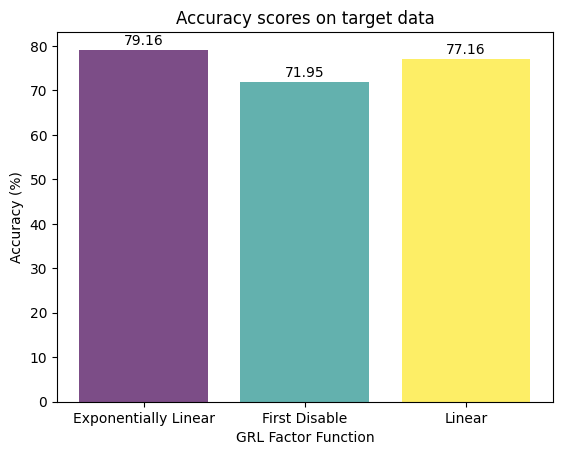

In [185]:
GRL_factor_function = ['Exponentially Linear', 'First Disable', 'Linear']
accuracies = [79.16, 71.95, 77.16]

colors = plt.cm.viridis(np.linspace(0, 1, len(GRL_factor_function)), alpha=0.7)

bars = plt.bar(GRL_factor_function, accuracies, color=colors)

for bar, v in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(v),
             color='black', ha='center', va='bottom')

plt.xlabel('GRL Factor Function')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy scores on target data')
plt.show()

## Domain adaptation with Semi-Supervised Learning

- ***Semi-supervised learning*** approaches offer interesting avenues to explore when the data to which we have access are only partially labeled. This strategie make it possible to take advantage of the information contained in unlabeled data in order to improve the performance of the final model. The approche propose to incorporate this information within the training or the structure of the model, while continuing to exploit the labeled data as is the case in standard supervised learning.

- We will enumerate some of the techniques employed in Semi-Supervised Learning, and we will implement the first two in this notebook using the MNIST and MNIST-M datasets.


1 - ***Self Training***: also known as **pseudo labeling**, is a semi-supervised learning technique where a model is trained on the available labeled data and then used to predict labels for unlabeled data. These pseudo-labeled predictions are then added to the labeled dataset to retrain the model.

2 - ***Co-Training***: is a semi-supervised learning approach that involves two models, each trained on a different subset of the available data. These models complement each other by labeling the most uncertain unlabeled data instances for each other. This approach is based on the assumption that different models can provide complementary information.

3 - ***Labeling with Generative Models***: Labeling with generative models involves using generative models, such as GANs (Generative Adversarial Networks), to assist in the labeling of unlabeled data. These generative models can generate synthetic labeled data points, helping to expand the labeled dataset.

4 - ***Labeling with Graphs***: Labeling with graphs is a semi-supervised learning technique that leverages the relationships between data points represented as a graph or network structure. It involves propagating labels through the graph based on the labels of neighboring data points, enhancing the labeling process.